In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
data = pd.read_csv('cleaned_train.csv')
X = data['description']
y = data['genre']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Preprocess the text data (TF-IDF Vectorization)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

In [21]:
# Train the individual models
from imblearn.ensemble import BalancedRandomForestClassifier


rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

D:\python workspace\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
D:\python workspace\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
D:\python workspace\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


BalancedRandomForestClassifier(random_state=42)

In [22]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [24]:
rf_preds_train = rf_model.predict_proba(X_train_tfidf)
lr_preds_train = lr_model.predict_proba(X_train_tfidf)

In [25]:
rf_preds_test = rf_model.predict_proba(X_test_tfidf)
lr_preds_test = lr_model.predict_proba(X_test_tfidf)

In [26]:
X_meta_train = np.hstack((rf_preds_train, lr_preds_train))
X_meta_test = np.hstack((rf_preds_test, lr_preds_test))

In [27]:
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_meta_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [28]:
meta_preds = meta_model.predict(X_meta_test)


In [29]:
print("Classification Report:")
print(classification_report(y_test, meta_preds))

print("Accuracy Score:", accuracy_score(y_test, meta_preds))

Classification Report:
               precision    recall  f1-score   support

      action        0.43      0.30      0.35       263
       adult        0.55      0.38      0.44       112
   adventure        0.37      0.24      0.29       139
   animation        0.33      0.19      0.24       104
   biography        0.00      0.00      0.00        61
      comedy        0.54      0.59      0.56      1443
       crime        0.28      0.10      0.15       107
 documentary        0.71      0.80      0.75      2659
       drama        0.56      0.74      0.64      2697
      family        0.40      0.15      0.22       150
     fantasy        0.33      0.01      0.03        74
   game-show        0.73      0.55      0.63        40
     history        0.17      0.02      0.04        45
      horror        0.65      0.62      0.63       431
       music        0.53      0.52      0.52       144
     musical        0.20      0.08      0.11        50
     mystery        0.40      0.11      0

D:\python workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\python workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\python workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(lr_model, file)
with open('meta_model.pkl', 'wb') as file:
    pickle.dump(meta_model, file)

In [31]:
def predict_genre(description):
    # Preprocess the description
    X_tfidf = vectorizer.transform([description])
    # Get predictions from the individual models
    rf_preds = rf_model.predict_proba(X_tfidf)
    lr_preds = lr_model.predict_proba(X_tfidf)
    
    # Stack the predictions
    X_meta = np.hstack((rf_preds, lr_preds))
    
    # Make the final prediction using the meta-model
    meta_pred = meta_model.predict(X_meta)
    return meta_pred[0]


In [33]:

# Example usage
new_description = input()
predicted_genre = predict_genre(new_description)
print(f"Predicted genre: {predicted_genre}")

 A U.S. Army officer serving in Vietnam is tasked with assassinating a renegade Special Forces Colonel who sees himself as a god.


Predicted genre:  documentary 


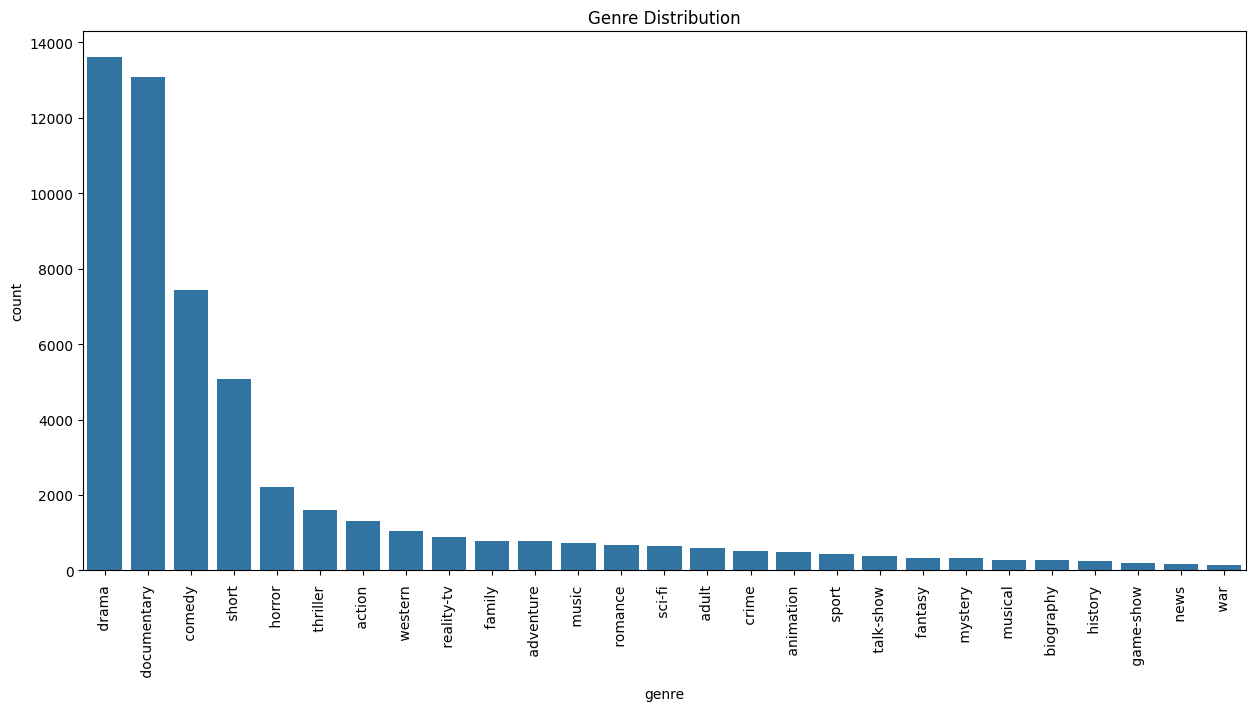

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data` is your DataFrame
plt.figure(figsize=(15,7))

# Create a count plot instead of a bar plot to count the occurrences of each genre
sns.countplot(data=data, x='genre', order=data['genre'].value_counts().index)

plt.title('Genre Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many genres
plt.show()


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `data` is your DataFrame
plt.figure(figsize=(15,7))

# Create a count plot instead of a bar plot to count the occurrences of each genre
sns.countplot(data=data, x='genre', order=X_train_p)

plt.title('Genre Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels if there are many genres
plt.show()


KeyboardInterrupt: 

In [39]:
X_train_pca

array([[ 0.01262704,  0.00663513, -0.00562956, ...,  0.01327907,
        -0.02951352, -0.00872476],
       [-0.06984215,  0.01918102,  0.03030687, ..., -0.00287302,
        -0.0115339 ,  0.00397458],
       [ 0.09338264, -0.03022803, -0.0689417 , ..., -0.03063071,
         0.01945672,  0.01749617],
       ...,
       [-0.08411851,  0.03067539,  0.0048497 , ...,  0.06201826,
        -0.01984706,  0.02597738],
       [ 0.02972078, -0.07398635,  0.01151692, ..., -0.01323498,
        -0.0122325 ,  0.01693042],
       [ 0.08961462, -0.00875971, -0.06780279, ...,  0.08233731,
         0.01954046, -0.00428648]])